# Gaussian process classification

### Pablo G. Moreno
### 2018.10.25

In [1]:
import numpy as np
import mxnet as mx
%matplotlib inline
from pylab import *
mx.random.seed(0)
np.random.seed(0)

/Users/morepabl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1-dimensional model

For this toy example, we assume we have the following inputs and outputs:

In [2]:
X = np.linspace(0,20,100).reshape(-1,1)
Y = np.zeros((X.shape[0], 3))
for oo in np.arange(3):
    Y[:, oo] = np.where((np.sin(X + np.random.randn()*0.9) + np.random.randn(*X.shape)*0.1)>0, 1,0)[:, 0]

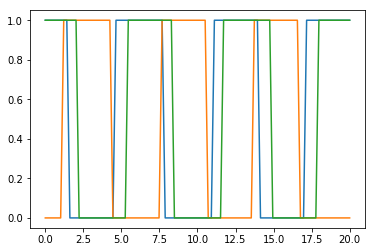

In [3]:
plt.plot(X,Y)

In [4]:
Xtt = X[50:-1,:]
Ytt = Y[50:-1,:]
X = X[0:50,:]
Y = Y[0:50,:]

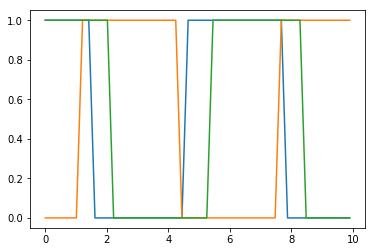

In [5]:
plt.plot(X,Y)

In [6]:
from mxfusion.components.distributions.gp.kernels import RBF

In [7]:
dtype = 'float64'

In [8]:
from mxfusion import Model, Variable
from mxfusion.modules.gp_modules import SVGPClassification
from mxfusion.components.variables.var_trans import PositiveTransformation

m = Model()
m.N = Variable()
m.x = Variable(shape=(m.N, 1))
kernel = RBF(input_dim=1, variance=1., lengthscale=1., dtype=dtype)
inducing_num = 10
Z_init = X[np.random.permutation(X.shape[0])[:inducing_num]]
inducing_inputs = Variable(shape=(inducing_num, kernel.input_dim), initial_value=Z_init)
m.y = SVGPClassification.define_variable(X=m.x, kernel=kernel, shape=Y.shape, 
                                   dtype=dtype, inducing_inputs=inducing_inputs)

In [9]:
# infr.initialize(x=mx.nd.array(X, dtype=dtype), y=mx.nd.array(Y, dtype=dtype))
# infr.params[m.y.factor.inducing_points] = ...

In [10]:
from mxfusion.inference import GradBasedInference, MAP
infr = GradBasedInference(inference_algorithm=MAP(model=m, observed=[m.x, m.y]), dtype=dtype)
for i in range(3):
    infr.run(x=mx.nd.array(X, dtype=dtype), y=mx.nd.array(Y, dtype=dtype), max_iter=100, learning_rate=0.1, verbose=True)

/Users/morepabl/workspace/MXFusion/mxfusion/inference/inference_parameters.py:59: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


Iteration 11 loss: 135.08151291670737
Iteration 21 loss: 102.54466946859434
Iteration 31 loss: 97.429449346459397
Iteration 41 loss: 94.46146827940125
Iteration 51 loss: 91.96632691669436
Iteration 61 loss: 89.98742317404026
Iteration 71 loss: 88.30343252499682
Iteration 81 loss: 86.79703813710668
Iteration 91 loss: 85.43449492257537
Iteration 100 loss: 84.32582958619443

/Users/morepabl/workspace/MXFusion/mxfusion/inference/inference.py:113: UserWarning: Trying to initialize the inference twice, skipping.
  warnings.warn("Trying to initialize the inference twice, skipping.")


Iteration 11 loss: 64.39940877769858
Iteration 21 loss: 59.16883440020008
Iteration 31 loss: 55.887666305480176
Iteration 41 loss: 53.718217156672494
Iteration 51 loss: 52.301591287093594
Iteration 61 loss: 51.271667134127645
Iteration 71 loss: 50.480065176708154
Iteration 81 loss: 49.839382085181784
Iteration 91 loss: 49.302033980914274
Iteration 11 loss: 48.429831795915675
Iteration 21 loss: 47.381222390459385
Iteration 31 loss: 46.720169572250854
Iteration 41 loss: 46.184320193853594
Iteration 51 loss: 45.739074066626386
Iteration 61 loss: 45.362059616520696
Iteration 71 loss: 45.033785314533625
Iteration 81 loss: 44.740604062232606
Iteration 91 loss: 44.477304487509606
Iteration 100 loss: 44.26211710842477

In [11]:
from mxfusion.inference import TransferInference, ModulePredictionAlgorithm
infr_pred = TransferInference(ModulePredictionAlgorithm(model=m, observed=[m.x], target_variables=[m.y]), 
                              infr_params=infr.params)

In [12]:
Xall = np.concatenate((X,Xtt))
Yall = np.concatenate((Y,Ytt))

In [13]:
res = infr_pred.run(x=mx.nd.array(Xall, dtype=dtype))[0]

/Users/morepabl/workspace/MXFusion/mxfusion/inference/inference_parameters.py:59: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


In [14]:
y_mean, y_lb, y_ub = res[0].asnumpy()[0], res[1].asnumpy()[0], res[2].asnumpy()[0]

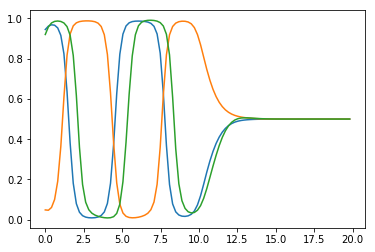

In [15]:
plot(Xall, y_mean.T)

In [16]:
y_lb.shape

(3, 99)

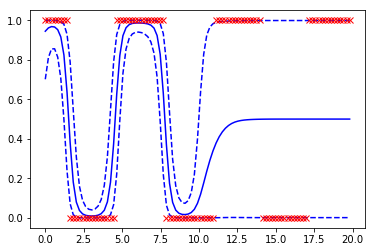

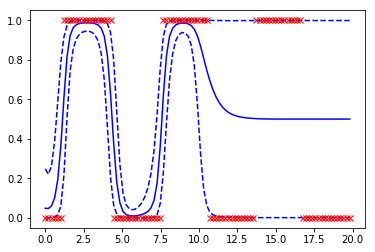

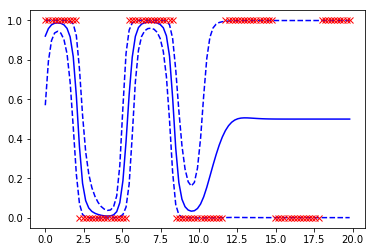

In [17]:
for dd in range(Yall.shape[1]):
    plot(Xall, y_mean[dd,:], 'b-')
    plot(Xall, y_lb[dd,:], 'b--')
    plot(Xall, y_ub[dd,:], 'b--')
    plot(Xall, Yall[:,dd], 'rx')
    plt.figure()

In [18]:
from mxfusion.inference import TransferInference, ModulePredictionAlgorithm
from mxfusion.modules.gp_modules.svgp_classification import SVGPClassificationSamplingPrediction
infr_pred = TransferInference(ModulePredictionAlgorithm(model=m, observed=[m.x], target_variables=[m.y], num_samples=5), 
                              infr_params=infr.params)
gp = m.y.factor
gp.attach_prediction_algorithms(targets=gp.output_names, conditionals=gp.input_names,
            algorithm=SVGPClassificationSamplingPrediction(
                gp._module_graph, gp._extra_graphs[0], [gp._module_graph.X]), 
            alg_name='gp_predict')
gp.gp_predict.jitter = 1e-6

In [19]:
xt = np.linspace(0,20)[:, None]
y_samples = infr_pred.run(x=mx.nd.array(xt, dtype=dtype))[0].asnumpy()

/Users/morepabl/workspace/MXFusion/mxfusion/inference/inference_parameters.py:59: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


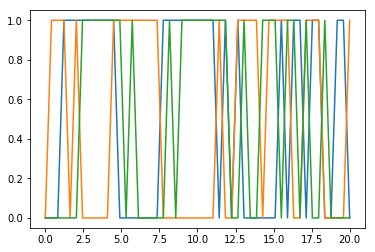

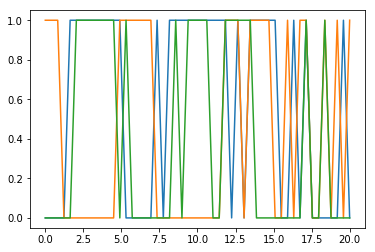

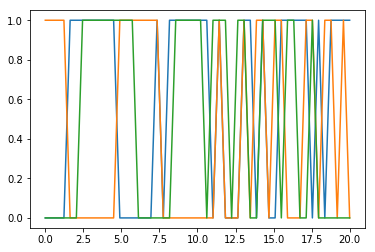

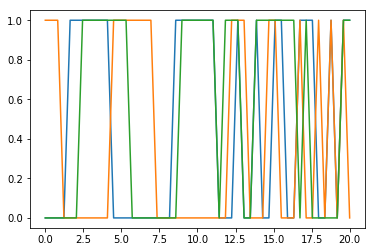

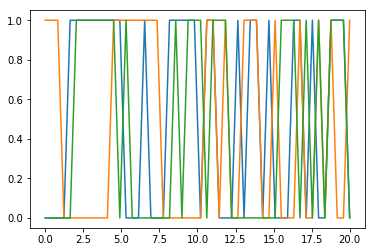

In [20]:
for i in range(y_samples.shape[0]):
    plot(xt, y_samples[i,:,:].T)
    plt.figure()